In [17]:
import numpy as np
import ntpath
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mtimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
import cv2
from imgaug import augmenters as iaa
import os
import random
import numpy as np
import tensorflow as tf

In [2]:
path = 'Data/driving_data.npz'
data = np.load(path)

In [3]:
input_angle_data = data['angle']
input_image_path = data['images_paths']

In [4]:
non_forward_indexes = np.where(input_angle_data != 90)
forward_indexes = np.where(input_angle_data == 90)
non_forward_angles = input_angle_data[non_forward_indexes]
non_forward_img_paths = input_image_path[non_forward_indexes]
print(len(forward_indexes[0]))
print(len(non_forward_angles))

2080
2737


In [5]:
'''indexes = np.where(input_angle_data == 90)
indexes = indexes[0]
forward_indexes = indexes[:200]
trainable_forward_angle = input_angle_data[forward_indexes]
trainable_forward_img_paths = input_image_path[forward_indexes]
print(len(trainable_forward_angle))
print(len(trainable_forward_img_paths))'''


'indexes = np.where(input_angle_data == 90)\nindexes = indexes[0]\nforward_indexes = indexes[:200]\ntrainable_forward_angle = input_angle_data[forward_indexes]\ntrainable_forward_img_paths = input_image_path[forward_indexes]\nprint(len(trainable_forward_angle))\nprint(len(trainable_forward_img_paths))'

In [6]:
'''steering_angles = np.concatenate((trainable_forward_angle, non_forward_angles), axis= 0)
img_path = np.concatenate((trainable_forward_img_paths, non_forward_img_paths), axis= 0)
print(len(steering_angles))
print(len(img_path)) '''
steering_angles = data['angle']
img_path = data['images_paths']
print(len(steering_angles))
print(len(img_path))

4817
4817


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(img_path, steering_angles, test_size = 0.2, random_state = 6)
print(len(X_train))
print(len(X_test))

3853
964


In [8]:
def path_preprocess(img):
    img = img[50:, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200,66))
    img = img/255
    return img

In [9]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = 180-steering_angle
    return image, steering_angle

In [10]:
def random_augment(image, steering_angle):
    image = mtimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle

0


Text(0.5, 1, 'Preprocessed Image')

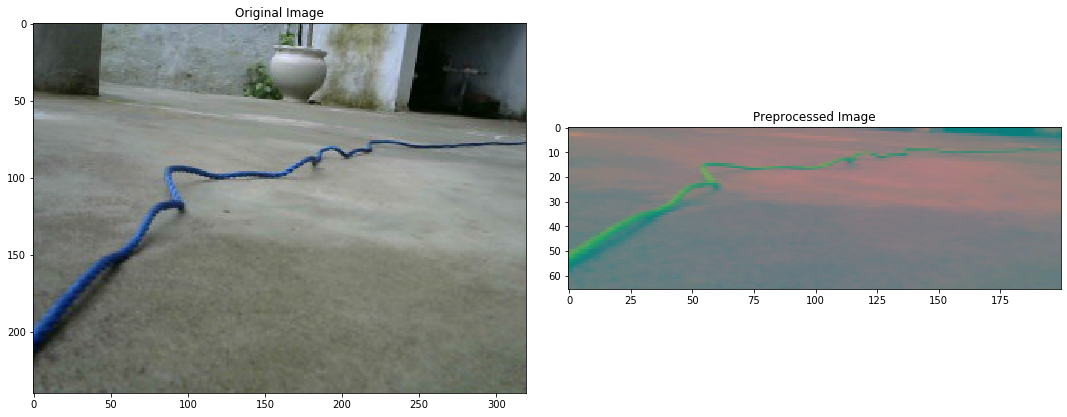

In [11]:
img = X_train[1000]
print(Y_train[1000])
oi = mtimg.imread(img)
ppi = path_preprocess(oi)
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(oi)
axs[0].set_title('Original Image')
axs[1].imshow(ppi)
axs[1].set_title('Preprocessed Image')

In [12]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mtimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = path_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  

In [13]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, (5,5), strides= (2,2), input_shape = (66, 200, 3), activation = 'elu'))
    model.add(Convolution2D(36, (5,5), strides= (2,2), activation = 'elu'))
    model.add(Convolution2D(48, (5,5), strides= (2,2), activation = 'elu'))
    model.add(Convolution2D(64, (3,3), activation = 'elu'))
    model.add(Convolution2D(64, (3,3), activation = 'elu'))
    #model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation = 'elu'))
    #model.add(Dropout(0.5))
    model.add(Dense(50, activation = 'elu'))
    model.add(Dense(10, activation = 'elu'))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer = Adam(lr = 1e-3))
    return model

In [14]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [15]:
history = model.fit_generator(batch_generator(X_train, Y_train, 100, 1), steps_per_epoch = 300, epochs = 10, 
                              validation_data = batch_generator(X_test, Y_test, 100, 0), validation_steps = 200,verbose = 1, shuffle = 1)

W0730 18:05:21.105088 4443565504 deprecation.py:323] From <ipython-input-15-695702149304>:2: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.
W0730 18:05:21.563279 4443565504 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0730 18:05:21.992399 4443565504 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 300 steps, validate for 200 steps
Epoch 1/10
300/300 [==============================] - 167s 555ms/step - loss: 2538.0047 - val_loss: 2898.2757
Epoch 2/10
300/300 [==============================] - 180s 601ms/step - loss: 2144.8463 - val_loss: 1886.3529
Epoch 3/10
300/300 [==============================] - 192s 639ms/step - loss: 1697.7706 - val_loss: 1236.0691
Epoch 4/10
300/300 [==============================] - 187s 623ms/step - loss: 1183.6365 - val_loss:

Text(0.5, 1.0, 'Loss')

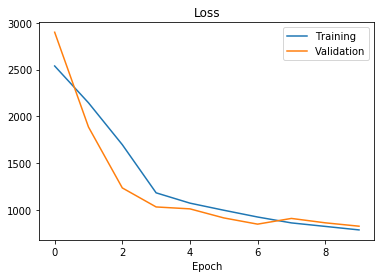

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.title("Loss")

In [60]:
model.save('driver_test3.h5')


In [61]:
from PIL import Image
from keras.models import load_model

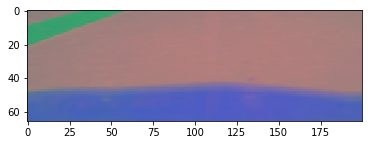

In [87]:
model = tf.keras.models.load_model('driver_test3.h5')
img = Image.open('3.jpg')
#print(Y_train[1000])
img = np.asarray(img)
img = path_preprocess(img)
plt.imshow(img)
img = np.array([img])

In [88]:
angle = model.predict(img)
print(int(angle[0][0]))

88
